# Testing Notebook

## Constant

In [1]:
class Sun:
    """
    Class to provide solar constants:
    
    mass -> kg
    radius -> m
    logg -> dex
    luminosity -> W
    large separation -> c/d
    Teff -> K
    Z -> dex
    """
    mass = 1.9885*10**30 #kg
    radius = 695700*10**3 #m
    logg = 2.43775056 #dex
    lum = 3.828*10**26 #W
    teff = 5772 #K
    delta_nu = 11.64672 #c/d

In [3]:
Sun.radius

695700000

In [4]:
11.64672*1000000/(24*3600)

134.8

## Freq_analysis

### harmonics

In [ ]:
import pandas as pd
import itertools as it
import numpy as np

def harmonics(freqs:pd.DataFrame, n:int, freqs_to_combine:int, err:float, f_col:int=0, amp_col:int=1) -> pd.DataFrame:
    """
    Function to find the harmonics 

    Parameters
    ----------

    freqs: pd.DataFrame
        Frequencies to evaluate in a DataFrame containing an amplitude column.
    
    n: int
        Maximum harmonic to find, from -n..., 0, ..., n

    freqs_to_combine: int
        Determines how many frequencies will be used to compute the harmonics.

    err: float
        Tolerance to consider a harmonic and a frequency the same frequency. Typically Rayleigh frequency.

    f_col: int
        Frequency column. Consider 0 as first column. Default = 0

    amp_col: int
        Amplitude column. Consider 0 as first column. Default = 1

    Output
    ------

    Dataframe containing the original frequencies, harmonics and the harmonic combination found.

    Example
    -------
        For instance, if freqs_to_combine = 3:

        f = n_i·f_0 + n_j·f_2 with n_i,j from -n to n.

        OR

        f = n_i·f_0+ n_j·f_1
    """

    # 1. Sorting the frequencies per amplitude
    columns = freqs.columns
    freqs_sorted = freqs.sort_values(by=columns[amp_col], ascending=False).reset_index(drop=True)
    structure = freqs_sorted.copy()
    fre = np.array(structure.iloc[:,f_col])

    # 2. Calculate all the possible combinations (including harmonics)
    # 2.1 In case number of frequencies is higher than the actual list, updating freqs_to_combine
    if freqs_to_combine > len(fre):
        freqs_to_combine = len(fre)
    product = list(it.product(range(1,freqs_to_combine+1),range(n,-(n+1),-1)))
    combination = list(it.combinations(product,2)) #Pairs of combination

    # 3. List containing the results [(frequency number,combination)]
    possible_combinations = []

    for pair in combination:
        #We avoid pairs of the same frequency and negative values of the combination to not repeat opperations
        if ( ( (pair[0][0] != pair[1][0]) or (pair[1][1] == 0) ) and ( (pair[0][1]*fre[pair[0][0]-1]+pair[1][1]*fre[pair[1][0]-1]) > 0 ) ):
            differencies = abs(fre - (pair[0][1]*fre[pair[0][0]-1]+pair[1][1]*fre[pair[1][0]-1])) #Differencies with all the frequencies
            differencies_under_tol = np.where(differencies <= err)
            if differencies_under_tol[0].size > 0:
                fre_id = int(differencies_under_tol[0][0]+1) #Just the first coincidence
                possible_combinations = possible_combinations+[(fre_id,)+pair]

    possible_combinations = sorted(possible_combinations) #We order the structure

    # 4. Now, complete the Combinations columns
    structure.insert(0,'ID', ['F'+str(i) for i in range(1,len(fre)+1)])
    f = [(0, (len(fre)+2, 0), (len(fre)+2, 0))] #We initialize a variable to allow to select the combination involving the first frequencies
    comb = []
    for m in possible_combinations:
        if ( m[1][1] == 0 and m[2][1] != 1 and m[2][0] != m[0] ):
            comb = str(m[2][1])+'*F'+str(m[2][0])
        elif ( m[2][1] == 0 and m[1][1] != 1 and m[1][0] != m[0] ):
            comb = str(m[1][1])+'*F'+str(m[1][0])
        elif ( m[1][0] < m[0] and m[2][0] < m[0] ):
            if m[2][1] > 0:
                comb = str(m[1][1])+'*F'+str(m[1][0])+'+'+str(m[2][1])+'*F'+str(m[2][0])
            else:
                comb = str(m[1][1])+'*F'+str(m[1][0])+str(m[2][1])+'*F'+str(m[2][0])

        # 4.1 Here we select the lowest combinations
        if ( comb != []):
            if ( m[0] != f[0]): #This is to add a combination for the next frequency
                structure.loc[m[0]-1, 'Combinations'] = comb
                f = m
            elif (m[0] == f[0] and m[1][0]+m[2][0] < f[1][0]+f[2][0]): #This is to select the lowest frequency for the combination
                structure.loc[m[0]-1, 'Combinations'] = comb
                f = m

        comb = [] # 4.2 Re-initialize this structure

    return pd.DataFrame(data=structure)

In [118]:
freqs = {'Freqs': [2, 4, 6, 8, 20], 'Amps': [13, 45, 6, 7, 2]}

freqs_df = pd.DataFrame(data=freqs)
freqs_df

,Freqs,Amps
0,2,13
1,4,45
2,6,6
3,8,7
4,20,2


In [119]:
test = harmonics(freqs=freqs_df, n=5, freqs_to_combine=7, err=0)
test

,ID,Freqs,Amps,Combinations
0,F1,4,45,2*F2
1,F2,2,13,NaN
2,F3,8,7,2*F1
3,F4,6,6,-1*F1+5*F2
4,F5,20,2,5*F1


### freq_resolver

In [8]:
from intervaltree import IntervalTree

In [50]:
def freq_resolver(freqs:pd.DataFrame, err:float, f_col:int=0, amp_col:int=1, type:str='close-open'):
    """
    This function evaluates if there are frequencies closer than err (e.g. the Rayleigh frequency). It will take the highest amplitude's as the real value.

    Parameters
    ----------

    freqs: pd.DataFrame
        DataFrame containing the frequencies and amplitudes

    err: float
        Tolerance value. Resolving power. For frequencies closer than this value, the one with highest amplitude will be considered the real one

    f_col: int
        Index of the column containing frequencies.

    amp_col: int
        Index of the column containing amplitudes.

    type: str
        Type of error interval

            'close' = [-err, err]

            'open' = (-err, err)

            'close-open' = [-err, err)

            'open-close' = (-err, err]

    Output
    ------

    Frequency dataframe with only frequencies that are spaced more than err.
    """

    # 1. Extracting frequencies and amplitudes values
    columns = freqs.columns
    fs = freqs[columns[f_col]].values
    amps = freqs[columns[amp_col]].values
    err0 = err
    eps = 10**-8

    limits = {
        'close': [err, err+eps],
        'open' : [err-eps, err-eps],
        'close-open': [err, err],
        'open-close': [err-eps, err+eps]
    }
    

    #2. We create an interval tree to consider the overalps within err
    tree = IntervalTree()

    #3. We defined the resolved frequencies
    resolved = []

    # 4. Loop over the frequencies
    for i, f in enumerate(fs):

        # 4.1 Check if the frequency is within any tolerance range in the tree
        overlaps = tree.overlap(f-err/2, f+err/2)

        # 4.2 Adding to the tree in case there is no overlaps
        if not overlaps:
            tree.addi(f-limits[type][0]/2, f+limits[type][1]/2, i) #begin, end, index
            resolved.append(i)
            continue

        # 4.3 If the frequency does overlaps, comparing amplitudes
        best = i
        for iv in overlaps:
            j = iv.data
            if amps[j]>amps[i]:
                best = j

        # 4.4 If the current one is still the best, we replace and remove the rest that overlaps the current one
        if best == i:
            for iv in overlaps:
                tree.remove(iv)
                resolved.remove(iv.data)
            
            # 4.4.1 Inserting the current one
            tree.addi(f-limits[type][0]/2, f+limits[type][1]/2, i)
            resolved.append(i)

    return freqs.iloc[resolved].reset_index(drop=True)




In [55]:
test = freq_resolver(freqs=freqs_df, err=4, type='open-close')
test

,Freqs,Amps
0,4,45
1,20,2


In [24]:
freqs_df

,Freqs,Amps
0,2,13
1,4,45
2,6,6
3,8,7
4,20,2


### window_function

In [ ]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

def window_function(t:np.ndarray, f_min:float, f_max:float, w:np.ndarray=None, resol:int=2000, method:str='Fourier', **ls_kwargs):
    """
    Calculate the normalised window function for f in [f_min, f_max] for a given time series.

    W(f) = | sum_j w_j * exp(-2π i f t_j) |^2

    Parameters
    ----------

    t: np.ndarray
        Time array.

    f_min: float
        Minimum frecuency for which the window function will be computed

    f_max: float
        Maximum frecuency for which the window function will be computed

    w: np.ndarray
        Weights of the sum components. All 1 by default

    resol: int
        - "Fourier": Resolution in frequency, i.e. the how many frequency to compute between f_min and f_max
        - "LombScargle": Oversampling factor

    method: str
        Method to compute the window function.
            - "Fourier": Classical theoretical FT of the window function.
            - "LombScargle": Compute the LombScargle periodogram of the window function. LombScargle from astropy.timeseries
    
    ls_kwargs: any
        kwargs for astropy.timeseries.LombScargle periodogram.

    Output
    ------

    W(f) in a np.ndarray format with 2 columns (N,2) [freq, W(f)]. Output is normalized by the maximum value
    """
    if method == 'Fourier':
        # 1. Assigning weights if they are not
        if w is None:
            w = np.ones_like(t)

        # 2. Defining the frequency span interval
        freqs = np.linspace(f_min, f_max, resol)

        # 3. Creating the window function array as a complex vector
        W = np.zeros_like(freqs, dtype=np.complex128)

        # 4. Computing W for every frequency in blocks to not burn out RAM
        block = 2000
        for i in range(0, len(freqs), block):
            f_block = freqs[i:i+block]

            # 4.1 Computing the exponential
            exponent = -2j*np.pi*np.outer(f_block, t) # Outer of a ^ b (column vectors) is the same as the matritial product of a·b^T. 

            # 4.2 Computing W with the weights as a matrix product
            W[i:i+block] = np.exp(exponent) @ w #

        # 4.3 Returning the output
        window_normalized = np.abs(W)**2/(np.max(np.abs(W)**2))
        window_matrix_normalized = np.column_stack((freqs ,window_normalized))

    elif method == 'LombScargle':

        # 1. Creating the array with all fluxes set to 1
        flux = np.ones_like(t)

        # 2. Computing LombScargle periodogram without centering data nor fitting mean
        ls = LombScargle(t=t, y=flux, center_data=False, fit_mean=False, **ls_kwargs)

        # 2.1 Getting the amplitude and frequencies
        freqs, window = ls.autopower(method='fast', maximum_frequency=f_max, samples_per_peak=resol)
        window_matrix_normalized = np.column_stack((freqs, window))
        
    else:
        raise ValueError(f"Unknown method: {method}")

    return window_matrix_normalized


In [208]:
path = '/Users/carloscamino/Library/CloudStorage/OneDrive-UNIVERSIDADDEGRANADA/01-Doctorado/02-Work_data/a-LOPS2/a-Paper/03-Results/to_remove/templates/raw/templates_raw_more_sectors/TIC40605940_S6-13_1800.0s_QLP_lc_c.fits'
with fits.open(path) as hdul:
    data = hdul[1].data
    time = data['TIME']

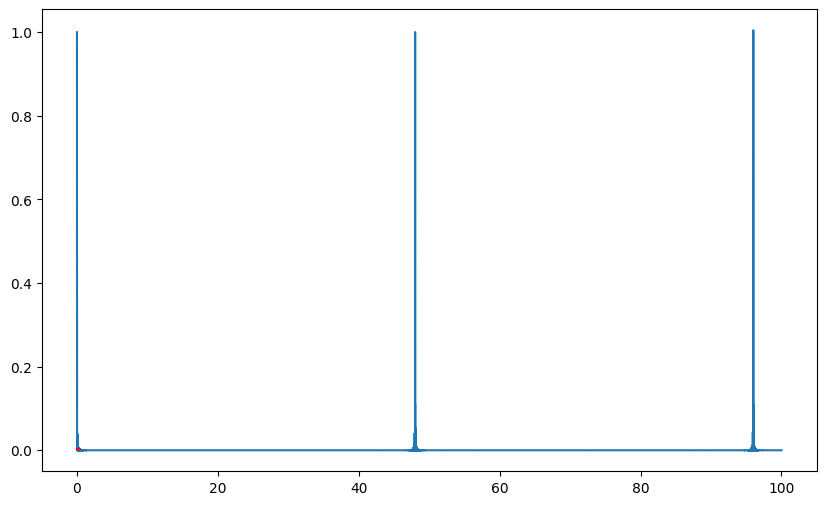

In [220]:
w_f = window_function(t=time, f_min=0, f_max=100, resol=10, method='LombScargle')

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.plot(w_f[:,0], w_f[:,1])
#ax1.set_ylim(0,0.02)
#ax1.set_xlim(47, 49)
ax1.vlines(np.linspace(0.075, 0.4,4), 0, 0.005, colors='red')

In [147]:
my_dict = {'f': np.linspace(0,100, 2000),
           'W(f)': w_f}
test = pd.DataFrame(data=my_dict)

test.sort_values(by='f', ascending=True).head(20)

,f,W(f)
0,0.000000,1.000000
1,0.050025,0.000267
2,0.100050,0.000326
3,0.150075,0.004726
4,0.200100,0.000718
5,0.250125,0.000016
6,0.300150,0.001466
7,0.350175,0.000216
8,0.400200,0.000016
9,0.450225,0.000154


In [149]:
np.median(my_dict['W(f)'])

np.float64(8.277862609450608e-07)

### antialiasing

In [111]:
import pandas as pd
import numpy as np
import os

def anti_aliasing(frequency_sample:pd.DataFrame, window_peaks:list, max_harmonic:int=3, save_file:bool=False, filename:str='test')-> pd.DataFrame:
    """
    Returns frequencies that are neither Nyquist nor window function aliased frequencies.

    Parameters
    ----------

    frequency_sample: pd.DataFrame
        Frequency Dataframe, preferably with amplitudes and frequency error estimation. Format must be
        Freqs, Amps, Freqs_error

    window_peaks: list
        List with all sources of aliasing, i.e. Nyquist frequency, window function 
        frequencies, known gap spacing frequencies
    
    max_harmonic: int
        Maximum integer to look for when applying f_alias = |f_real +/- f_wp|, 
        being f_wp the p-th frequency from the window peaks

    save_file: bool
        If true, a folder 'real_freqs' will be generated at your working directory containing a file
        where columns are Freqs, Amps, Freq_err, Alias. If alias frequency, harmonic combination is shown,
        else, column is empty.
    
    file_name: str (mandatory if save_file)
        Name of the file where freqs will be stored
    
    Output
    ------

    real_freqs: pd.DataFrame
        DataFrame with the same format as the file output and a Alias column where the combinations are written as n_i*f_i+/-n_j*f_wj,
        being i and j the index of the i-th and j-th real frequency and window frequency, respectively
    """

    real_frequencies = []
    all_combis = []
    columns = frequency_sample.columns
    frequency_sample.sort_values(by=columns[1], ascending=False, inplace=True, ignore_index=True)
    file_df = frequency_sample.copy()
    
    for row in frequency_sample.itertuples(index=False):
        is_alias = False
        f_peak = row[0]
        amp_peak = row[1]
        error_f_peak = row[2]
        combination = ''
        
        # === 1. DIRECT MATCH CHECK (vs. SWF peaks) ===
        # If the peak matches a window frequency, it's highly likely a sampling artifact.
        for i, f_w in enumerate(window_peaks):
            for n in range(1,max_harmonic+1):
                if abs(f_peak - n*f_w) < error_f_peak:
                    is_alias = True
                    combination = f"{n}*f_w{i}"
                    break
        
        if is_alias:
            all_combis.append(combination)
            continue
        
        # === 2. INVERSE ALIAS CHECK (vs. already accepted REAL peaks) ===
        # Is this peak (f_peak) an alias of a REAL frequency (f_real) already found?
        for i, f_real in enumerate(real_frequencies):
            
            
            # We only check against the window frequencies
            for j, f_w in enumerate(window_peaks):
                for n in range(1, max_harmonic + 1):
                    # Alias formulas: f_alias = |f_real ± n*f_w|
                    alias_sum = abs(f_real + n * f_w)
                    alias_sub = abs(f_real - n * f_w)
                    
                    # Dynamic Tolerance Check: Does f_peak fall within twice the error of the theoretical alias?
                    if abs(f_peak - alias_sum) <= error_f_peak:
                        
                        # Since data is sorted by amplitude, amp_peak <= amp_real,
                        # confirming this peak is a weaker "daughter" peak.
                        is_alias = True
                        combination = f"f_{i}+{n}*f_w{j}"
                        all_combis.append(combination)
                        break
                    elif abs(f_peak - alias_sub) <= error_f_peak:
                        is_alias = True
                        combination = f"f_{i}-{n}*f_w{j}"
                        all_combis.append(combination)
                        break

                if is_alias:
                    break

            if is_alias:
                break
        
        # === 3. ACCEPTANCE ===
        # If the peak fails all alias checks, it's accepted as a candidate for a real physical signal.
        if not is_alias:
            real_frequencies.append(f_peak)
            all_combis.append(np.nan)

    file_df['Alias'] = all_combis
    #file_df.sort_values(by=, ascending=False, inplace=True)
    if save_file:
        os.makedirs('real_freqs', exist_ok=True)
        file_df.to_csv('./real_freqs/'+filename
                       , index=False, header=True)
            
    return file_df

In [112]:
freqs = {'Freqs': [2, 4, 6, 8, 20], 'Amps': [13, 45, 6, 7, 2], 'err': [0, 0, 0, 0, 0]}

freqs_df = pd.DataFrame(data=freqs)
freqs_df

,Freqs,Amps,err
0,2,13,0
1,4,45,0
2,6,6,0
3,8,7,0
4,20,2,0


In [113]:
test = anti_aliasing(frequency_sample=freqs_df, window_peaks=[9], max_harmonic=8)
test

,Freqs,Amps,err,Alias
0,4,45,0,NaN
1,2,13,0,NaN
2,8,7,0,NaN
3,6,6,0,NaN
4,20,2,0,f_1+2*f_w0


### window_check

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from matplotlib.gridspec import GridSpec

In [222]:
def window_check(freqs:pd.DataFrame, f_col:int, amp_col:int, window_function:np.ndarray, max_n:int = 1, tol:float=0) -> pd.DataFrame:
    """
    This function evaluates the alias frequencies produced by the convolution of the window function and the real signal.

    An alias is identified if:

            |f_alias - f_real| = n·f_wf +/- tol  
    
    where f_wf are the frequencies of the window function. This function also evaluates the amplitudes compared to the 
    
    offered by window function, i.e. amplitudes of peaks suspected to be aliased frequencies will be checked if their 
    
    amplitudes are a factor of the window function power computed for f_wf.

    Parameters
    ----------

    freqs: pd.DataFrame
        DataFrame containing (Frequencies, Amplitudes) from the sample
    
    f_col: int
        Index column of the frequencies

    amp_col: int
        Index column of the amplitudes

    window_function: np.ndarray
        Array of shape (N,2) containing (Frequencies, W(f)) from the computed window function

    max_n: int
        Max integer to evaluate the spurious frequencies in the window function. Usually this value is 1, more than this value is

        not implemented yet.

    tol: float
        Tolerance or Error to consider a frequency an alias

    Output
    ------

        DataFrame with all the frequencies and an extra column indicating the combination 
        found for an alias frequency.
    """

    # 1. Finding the lowest amplitude detected in the real sample to see the lowest limit.
    #lowest_amp = freqs[:,1].min()

    # 2. Sorting the dataframe per amplitude
    columns = freqs.columns
    freqs_df_sorted = freqs.sort_values(by=columns[amp_col], ascending=False, ignore_index=True)
    freqs_matrix = freqs.iloc[:,[f_col,amp_col]].to_numpy()
    freqs_sorted = freqs_matrix[np.argsort(freqs_matrix[:,1])][::-1]
    freqs_list = freqs_sorted[:,0].copy()

    # 3. We first check if there are any observed frequency in the window function

    # 3.1 Creating a initial_check_matrix
    window_sorted = window_function[np.argsort(window_function[:,1])][::-1]
    window_list = window_sorted[:,0].copy()
    initial_check_matrix = freqs_list[:,None] - window_list[None,:] # f_real - f_wf

    # 3.2 Saving indexes of the observed frequencies that matched
    freqs_in_window_idx = np.argwhere(np.abs(initial_check_matrix) <= tol)

    # 4. We need to compute all the possible combinations of f_real +/- n·f_wf

    # 4.1 All n possible values (-n, -n+1,...0,...,n)
    n = np.arange(-max_n, max_n+1, 1)
    # 4.1.1 Discarding the n=0
    n = n[n!=0]
    # 4.2 Create a matrix win 2n+1 columns consisting of f_wf_i*n_j (f_wf x n)
    delta_matrix = np.outer(window_sorted[:,0], n)    
    
    # 5. We need to compute all the possible differences between all the frequencies

    # 5.1 Compute a matrix of f_i-f_j with both f_i and f_j sorted by amplitude (f_real x f_real)
    diffs_matrix = freqs_list[:,None] - freqs_list[None,:] # Broadcasting to be able to substract

    # 5.2 We need to compare which elements of |diffs_matrix - delta_matrix| <= tol (sólo nos quedamos con el primero)
    # 5.2.1 We expand dimensions to be able to substract (broadcasting)
    diffs_exp = diffs_matrix[:, :, None, None]       # (f_real, f_real, 1, 1)
    delta_exp = delta_matrix[None, None, :, :]       # (1, 1, f_wf, n)

    # 5.2.2 We take the boolean array where the match happens
    matches_id = np.abs(delta_exp-diffs_exp)<=tol

    # 5.2.3 We only select such that an alias is combination of stronger frequencies in amplitude (j<i)
    N = freqs_sorted.shape[0]
    i_idx, j_idx = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    mask_hierarchy = j_idx < i_idx
    mask_hierarchy = mask_hierarchy[:, :, None, None]   # broadcasting

    matches_id &= mask_hierarchy

    # 5.2.4 Selecting the index where this happens
    alias_candidates_idx = np.argwhere(matches_id) # (f_real, f_real, f_wf, n)

    # 6. Creating the output as a dataframe
    combinations = []
    labels=[]
    for freq_idx in range(N):
        # If frequency was in window function, it will have a zero in initial_check_matrix at that row
        if np.isin(freq_idx, freqs_in_window_idx[:,0]):
            # We need to take the index of the FW, which is the column index
            match_idx = freqs_in_window_idx[freqs_in_window_idx[:,0] == freq_idx]
            wf_idx = match_idx[0, 1]
            combinations.append(f"FW_{wf_idx}")

        #If frequency is an alias due to the window function
        elif np.isin(freq_idx, alias_candidates_idx[:,0]):
            matches = alias_candidates_idx[alias_candidates_idx[:,0] == freq_idx]
            main_f_idx = matches[0,1]
            wf_idx = matches[0,2]
            sign = "+" if matches[0,3] == 1 else "-"
            combinations.append(f"F{main_f_idx+1}{sign}FW{wf_idx}")

        #Real freq
        else:
            combinations.append(np.nan)

        labels.append(f"F{freq_idx+1}")

    # 7. Updating the DataFrame
    freqs_df_sorted['Combinations'] = combinations
    if 'ID' not in freqs_df_sorted.columns:
        freqs_df_sorted.insert(loc=0, column='ID', value=labels)


    return freqs_df_sorted

In [228]:
freqs_matrix = np.array([np.arange(1,4,0.2), np.linspace(8, 2, 15)]).transpose()
window_function = np.array(
    [[1,2, 0.5],
    [4,3,5]]
).transpose()

In [229]:
freqs_df = pd.DataFrame(freqs_matrix, columns=["Freqs", "Amps"])
freqs_df

,Freqs,Amps
0,1.0,8.000000
1,1.2,7.571429
2,1.4,7.142857
3,1.6,6.714286
4,1.8,6.285714
5,2.0,5.857143
6,2.2,5.428571
7,2.4,5.000000
8,2.6,4.571429
9,2.8,4.142857


In [230]:
window_function

array([[1. , 4. ],
       [2. , 3. ],
       [0.5, 5. ]])

In [232]:
window_check(freqs=freqs_df, f_col=0, amp_col=1, window_function=window_function, max_n=1, tol=0.01)

,ID,Freqs,Amps,Combinations
0,F1,1.0,8.000000,FW_1
1,F2,1.2,7.571429,NaN
2,F3,1.4,7.142857,NaN
3,F4,1.6,6.714286,NaN
4,F5,1.8,6.285714,NaN
5,F6,2.0,5.857143,FW_2
6,F7,2.2,5.428571,F2+FW1
7,F8,2.4,5.000000,F3+FW1
8,F9,2.6,4.571429,F4+FW1
9,F10,2.8,4.142857,F5+FW1


### Other Function